In [ ]:
import numpy as np
from scipy.optimize import linprog
import pandas as pd
import pulp
import networkx as nx
import matplotlib.pyplot as plt

1. Récupération des données

In [2]:
N = 3
fichiers_production = ['prodA.csv', 'prodB.csv', 'prodC.csv']
fichier_demande = 'demand2050_ademe.csv'

a. Traitement des fichiers de production (prodA, prodB, prodC)

In [3]:
liste_production_series = []

print("Chargement des fichiers de production...")
for nom_fichier in fichiers_production:
    try:
        df = pd.read_csv(nom_fichier)
        # On ajoute la colonne 'Production_Elec' convertie en float
        liste_production_series.append(df['Production_Elec'].astype(float))
        print(f"  - {nom_fichier} chargé avec succès.")
    except FileNotFoundError:
        print(f"Erreur : Le fichier {nom_fichier} n'a pas été trouvé.")

if liste_production_series:
    # Concaténation en une seule DataFrame avec colonnes pour chaque production
    # On s'assure que toutes les séries ont la même longueur
    min_len = min(len(s) for s in liste_production_series)
    # Tronque toutes les séries à la même longueur
    liste_tronquee = [s[:min_len] for s in liste_production_series]
    
    # Transformation en DataFrame (colonnes = prodA, prodB, prodC)
    df_production = pd.DataFrame({
        f'prod{i+1}': serie for i, serie in enumerate(liste_tronquee)
    })
    
    # Conversion en matrice numpy
    matrice_production = df_production.to_numpy()
    print("Matrice de production créée avec succès.")
else:
    matrice_production = np.array([])
    print("Aucun fichier de production n'a pu être chargé. La matrice est vide.")


Chargement des fichiers de production...
  - prodA.csv chargé avec succès.
  - prodB.csv chargé avec succès.
  - prodC.csv chargé avec succès.
Matrice de production créée avec succès.


b. Traitement du fichier de demande (demand2050_ademe.csv)

In [4]:
print("\nChargement du fichier de demande...")
try:
    df_demande = pd.read_csv(fichier_demande, header=None)
    vecteur_demande = df_demande.iloc[:, 1].astype(float).to_numpy()

    if matrice_production.size > 0:
        n_lignes, n_colonnes = matrice_production.shape
        # Nombre d’éléments par colonne
        L = len(vecteur_demande)
        taille_colonne = int(np.ceil(L / n_colonnes))

        # Créer une matrice vide
        matrice_demande = np.zeros((n_lignes, n_colonnes))

        for i in range(n_colonnes):
            start = i * taille_colonne
            end = start + n_lignes
            # Extraire la partie correspondante et compléter si nécessaire
            partie = vecteur_demande[start:end]
            if len(partie) < n_lignes:
                # compléter avec la dernière valeur de la partie
                partie = np.concatenate([partie, np.full(n_lignes - len(partie), partie[-1])])
            matrice_demande[:, i] = partie

    else:
        matrice_demande = np.array([])
        print("La matrice de production est vide, la matrice de demande ne peut pas être alignée.")

    print("Matrice de demande créée avec succès.")

except FileNotFoundError:
    matrice_demande = np.array([])
    print(f"Erreur : Le fichier {fichier_demande} n'a pas été trouvé.")

    
print(np.shape(matrice_demande))
print(np.shape(matrice_production))
print(matrice_demande)




Chargement du fichier de demande...
Matrice de demande créée avec succès.
(2920, 3)
(2920, 3)
[[28.6900142 52.2312379 45.2468095]
 [31.2084578 46.3139339 56.6973334]
 [27.6996061 46.33277   62.0020965]
 ...
 [58.1660071 31.6128117 36.7066712]
 [56.1246215 33.0292104 33.2898536]
 [54.4065208 37.3809909 28.6056381]]


Les deux matrices sont maintenant disponibles dans les variables `matrice_production` et `matrice_demande`.

- prod : matrice où les lignes representent pour chaque heure (prodA, prodB, prodC)
- demand : matrice où les lignes representent pour chaque heure (demandA, demandB, demandC)
- qmax : capacité maximale de flux entre deux pays
- N : nombre de pays
- T : nombre de périodes

In [5]:
qmax = 100
N,T=np.shape(matrice_demande)
print(N)
print(T)

2920
3


2. Ecriture de l'algorithme de résolution

In [6]:
import pulp
import numpy as np

def solve_flux(prod_matrix, demand_matrix, qmax_matrix):
    """
    Résout le flux optimal pour N pays et T périodes, avec PuLP.

    prod_matrix : np.array (T, N)
    demand_matrix : np.array (T, N)
    qmax_matrix : np.array (N, N), symétrique, diag = 0
    """

    T, N = prod_matrix.shape

    # Sécurité : contrôle taille qmax_matrix
    assert qmax_matrix.shape == (N, N), "qmax_matrix doit être de taille (N, N)"
    assert np.allclose(qmax_matrix, qmax_matrix.T), "qmax_matrix doit être symétrique"
    assert np.all(np.diag(qmax_matrix) == 0), "La diagonale de qmax_matrix doit être nulle"

    Q = prod_matrix - demand_matrix

    # Problème d'optimisation
    prob = pulp.LpProblem("Optimal_Flux", pulp.LpMinimize)

    # Flux inter-pays q[t,i,j]
    q = {}
    for t in range(T):
        for i in range(N):
            for j in range(N):
                if i != j:
                    q[t, i, j] = pulp.LpVariable(
                        f"q_{t}_{i}_{j}",
                        lowBound=0,
                        upBound=float(qmax_matrix[i, j])
                    )

    # Variables r_pos et r_neg
    r_pos, r_neg = {}, {}
    for t in range(T):
        for i in range(N):
            if Q[t, i] >= 0:
                r_pos[t, i] = pulp.LpVariable(f"r_pos_{t}_{i}", lowBound=0)
                r_neg[t, i] = pulp.LpVariable(f"r_neg_{t}_{i}", lowBound=0, upBound=0)
            else:
                r_pos[t, i] = pulp.LpVariable(f"r_pos_{t}_{i}", lowBound=0, upBound=0)
                r_neg[t, i] = pulp.LpVariable(f"r_neg_{t}_{i}", lowBound=0)

    # Fonction objectif
    prob += pulp.lpSum(r_neg[t, i] for t in range(T) for i in range(N))

    # Contraintes de bilan
    for t in range(T):
        for i in range(N):
            inflow = pulp.lpSum(q[t, j, i] for j in range(N) if j != i)
            outflow = pulp.lpSum(q[t, i, j] for j in range(N) if j != i)
            prob += (
                r_pos[t, i] - r_neg[t, i]
                == prod_matrix[t, i] - demand_matrix[t, i] + 0.9 * inflow - outflow
            )

    # Résolution
    solver = pulp.PULP_CBC_CMD(msg=False)
    prob.solve(solver)

    # Extraction solutions
    q_array = np.zeros((T, N, N))
    r_pos_array = np.zeros((T, N))
    r_neg_array = np.zeros((T, N))

    for t in range(T):
        for i in range(N):
            r_pos_array[t, i] = pulp.value(r_pos[t, i])
            r_neg_array[t, i] = pulp.value(r_neg[t, i])
            for j in range(N):
                if i != j:
                    q_array[t, i, j] = pulp.value(q[t, i, j])

    return q_array, r_pos_array, r_neg_array


3. Récupération des tests

In [51]:
q, r_pos, r_neg = solve_flux(matrice_production, matrice_demande, qmax)


T, N = r_pos.shape  # nombre de périodes et de pays

# Statistiques globales
nb_r_pos_positifs = np.sum(r_pos > 0)
nb_r_neg_positifs = np.sum(r_neg > 0)

print("----- Statistiques r⁺ et r⁻ (global) -----")
print("nb heures total :", T * N)
print("nb_r_pos_positifs:", nb_r_pos_positifs)
print("nb_r_neg_positifs:", nb_r_neg_positifs)
print("proportion de r negatifs", nb_r_neg_positifs / (T * N))
print("---------------------------------------")

# Statistiques par pays
for i, pays in enumerate(["A", "B", "C"]):
    nb_r_pos = np.sum(r_pos[:, i] > 0)
    nb_r_neg = np.sum(r_neg[:, i] > 0)
    print(f"Pays {pays}:")
    print("nb_r_pos_positifs:", nb_r_pos)
    print("nb_r_neg_positifs:", nb_r_neg)
    print("proportion de r negatifs", nb_r_neg / T)
    print("---------------------------------------")


----- Statistiques r⁺ et r⁻ (global) -----
nb heures total : 8760
nb_r_pos_positifs: 7390
nb_r_neg_positifs: 949
proportion de r negatifs 0.10833333333333334
---------------------------------------
Pays A:
nb_r_pos_positifs: 2312
nb_r_neg_positifs: 467
proportion de r negatifs 0.15993150684931506
---------------------------------------
Pays B:
nb_r_pos_positifs: 2584
nb_r_neg_positifs: 181
proportion de r negatifs 0.061986301369863016
---------------------------------------
Pays C:
nb_r_pos_positifs: 2494
nb_r_neg_positifs: 301
proportion de r negatifs 0.10308219178082192
---------------------------------------


Plus petit test

In [ ]:
N, T = 3, 5
prod = np.random.rand(T, N) * 10
dem = np.random.rand(T, N) * 8

Qmax = np.array([
    [0, 5, 3],
    [5, 0, 6],
    [3, 6, 0]
])

q, r_pos, r_neg = solve_flux(prod, dem, Qmax)
print(prod, dem, Qmax)

T, N = r_pos.shape  # nombre de périodes et de pays

# Statistiques globales
nb_r_pos_positifs = np.sum(r_pos > 0)
nb_r_neg_positifs = np.sum(r_neg > 0)

print("----- Statistiques r⁺ et r⁻ (global) -----")
print("nb heures total :", T * N)
print("nb_r_pos_positifs:", nb_r_pos_positifs)
print("nb_r_neg_positifs:", nb_r_neg_positifs)
print("proportion de r negatifs", nb_r_neg_positifs / (T * N))
print("---------------------------------------")

# Statistiques par pays
for i, pays in enumerate(["A", "B", "C"]):
    nb_r_pos = np.sum(r_pos[:, i] > 0)
    nb_r_neg = np.sum(r_neg[:, i] > 0)
    print(f"Pays {pays}:")
    print("nb_r_pos_positifs:", nb_r_pos)
    print("nb_r_neg_positifs:", nb_r_neg)
    print("proportion de r negatifs", nb_r_neg / T)
    print("---------------------------------------")



4. Interprétation graphique

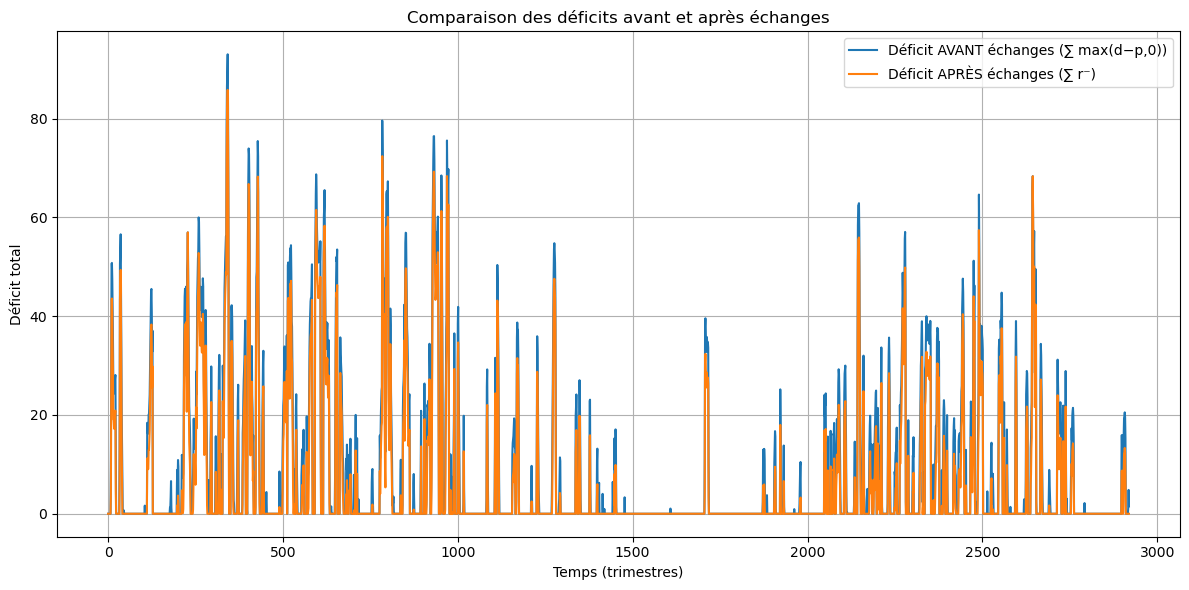

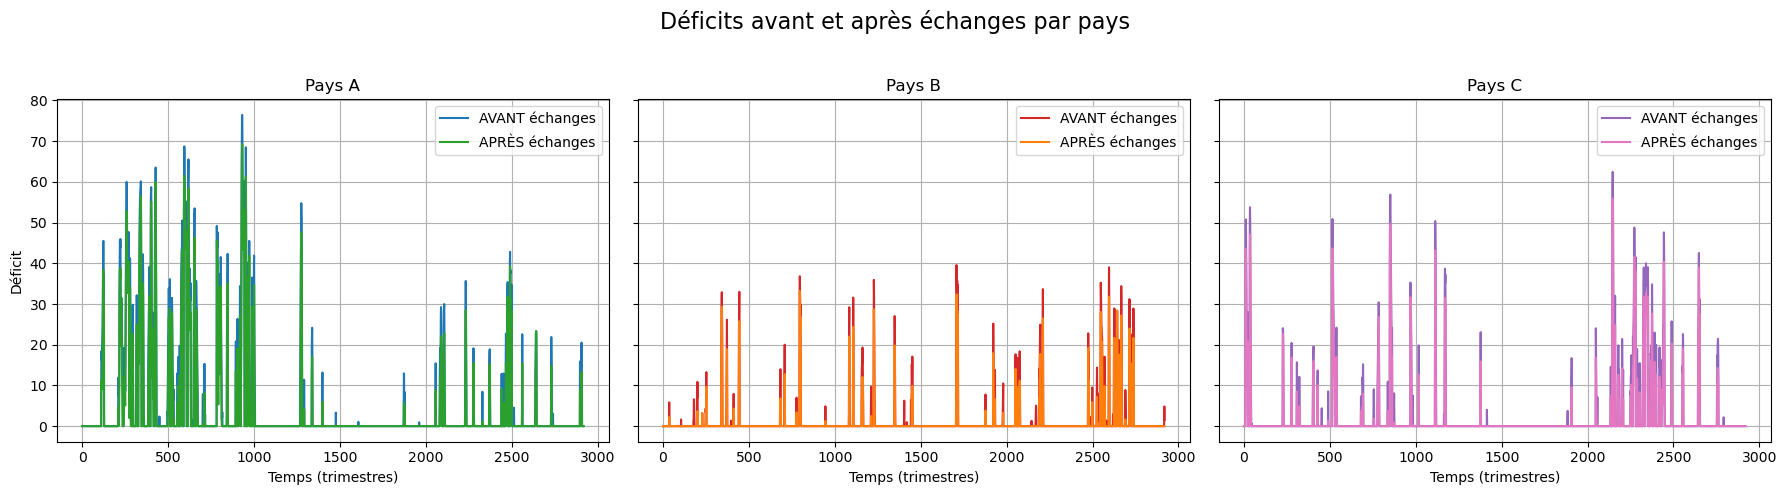

In [ ]:
# r_neg est déjà une matrice (T, N)
r_neg_sum = np.sum(r_neg, axis=1)  # somme par ligne → déficit total après échanges

# Déficit avant échanges
raw_deficit = np.maximum(matrice_demande - matrice_production, 0)
raw_deficit_sum = np.sum(raw_deficit, axis=1)  # somme par ligne → déficit total avant échanges

# Tracé
plt.figure(figsize=(12, 6))
plt.plot(raw_deficit_sum, label="Déficit AVANT échanges (∑ max(d−p,0))")
plt.plot(r_neg_sum, label="Déficit APRÈS échanges (∑ r⁻)")


plt.title("Comparaison des déficits avant et après échanges")
plt.xlabel("Temps (trimestres)")
plt.ylabel("Déficit total")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

pays_labels = ["A", "B", "C"]
couleurs_avant = ["tab:blue", "tab:red", "tab:purple"]
couleurs_apres = ["tab:green", "tab:orange", "tab:pink"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # 1 ligne, 3 colonnes

for i, ax in enumerate(axes):

    ax.plot(np.maximum(matrice_demande[:, i] - matrice_production[:, i], 0), color=couleurs_avant[i], label="AVANT échanges")
    ax.plot(r_neg[:, i], color=couleurs_apres[i], label="APRÈS échanges")

    ax.set_title(f"Pays {pays_labels[i]}")
    ax.set_xlabel("Temps (trimestres)")
    ax.grid(True)
    if i == 0:
        ax.set_ylabel("Déficit")
    ax.legend()

plt.suptitle("Déficits avant et après échanges par pays", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajuste l'espace pour le suptitle
plt.show()



Ebauchauche graphes orienté à un instant t :

In [ ]:
def plot_initial_graph(prod_matrix, demand_matrix, qmax_matrix, period=0):
    T, N = prod_matrix.shape
    assert 0 <= period < T

    G = nx.DiGraph()

    # Valeur aux noeuds = prod - demande
    Q = prod_matrix[period] - demand_matrix[period]
    for i in range(N):
        G.add_node(i, Q=Q[i])

    # Arêtes uniquement si qmax > 0
    for i in range(N):
        for j in range(N):
            if i != j and qmax_matrix[i, j] > 0:
                G.add_edge(i, j, qmax=qmax_matrix[i, j])

    # Position des noeuds
    pos = nx.spring_layout(G, seed=42)  # plus naturel

    # Couleur des noeuds
    node_colors = ['green' if G.nodes[i]['Q'] >= 0 else 'red' for i in G.nodes()]
    node_labels = {i: f"P{i}\nQ={G.nodes[i]['Q']:.2f}" for i in G.nodes()}

    # Épaisseur des arêtes proportionnelle à qmax
    edge_weights = [G.edges[i, j]['qmax'] for i, j in G.edges()]

    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=2000, width=edge_weights,
            edge_color='gray', arrowsize=20)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)
    edge_labels = {(i, j): f"{G.edges[i, j]['qmax']:.1f}" for i, j in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
    plt.title(f"Graphe des capacités - Période {period}")
    plt.show()


def plot_flux_graph(q_array, r_pos_array, r_neg_array, period=0):
    T, N, _ = q_array.shape
    assert 0 <= period < T

    G = nx.DiGraph()

    # Nœuds avec r
    for i in range(N):
        r = r_pos_array[period, i] - r_neg_array[period, i]
        G.add_node(i, r=r)

    # Arêtes avec flux non nuls
    for i in range(N):
        for j in range(N):
            v = q_array[period, i, j]
            if i != j and v > 1e-6:
                G.add_edge(i, j, flux=v)

    pos = nx.spring_layout(G, seed=42)

    # Couleur des nœuds selon r
    node_colors = ['green' if G.nodes[i]['r'] >= 0 else 'red' for i in G.nodes()]
    node_labels = {i: f"P{i}\nr={G.nodes[i]['r']:.2f}" for i in G.nodes()}

    # Épaisseur des arêtes proportionnelle au flux
    edge_weights = [G.edges[i, j]['flux'] for i, j in G.edges()]

    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=2000, width=edge_weights,
            edge_color='blue', arrowsize=25)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)
    edge_labels = {(i, j): f"{G.edges[i, j]['flux']:.2f}" for i, j in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
    plt.title(f"Graphe des flux optimisés - Période {period}")
    plt.show()

    

plot_initial_graph(prod, dem, Qmax, period=0)
plot_flux_graph(q, r_pos, r_neg, period=0)
